In [1]:
import sys
sys.path.append('../code/') 
sys.path.append('../externals/transformer/') 
from tst import Transformer

import mocap_functions
from functools import partial
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
from hnn_core.utils import smooth_waveform
from scipy.signal import savgol_filter
#sns.set()
#sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0")
device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

2023-03-13 22:24:49.917184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 22:24:50.215287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 22:24:50.215318: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 22:24:50.254512: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-13 22:24:51.034134: W tensorflow/stream_executor/platform/de

In [2]:
cam_idx = 1
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/', kinematic_suffix=f'_cam{cam_idx}')
num_trials = len(kinematic_df['trial'].unique())

null_percent = kinematic_df.groupby('name')['posData'].apply(list).map(
    np.concatenate).map(lambda x: np.sum(np.isnan(x)) / len(x))

pos_filter = [1, 4]
# pos_filter = [1, 2, 3, 4]
pos_remove_filter = [f'position_{pos_idx}' for pos_idx in [2,3]]
# layout_filter = [1,2,3,4]
layout_filter = [1,2]

layout_remove_filter = [f'layout_{layout_idx}' for layout_idx in []]


neural_df = neural_df[np.in1d(neural_df['position'], pos_filter)].reset_index(drop=True)
neural_df = neural_df[np.in1d(neural_df['layout'], layout_filter)].reset_index(drop=True)
neural_df = neural_df[~np.in1d(neural_df['unit'], pos_remove_filter)].reset_index(drop=True)
neural_df = neural_df[~np.in1d(neural_df['unit'], layout_remove_filter)].reset_index(drop=True)

kinematic_df = kinematic_df[np.in1d(kinematic_df['position'], pos_filter)].reset_index(drop=True)
kinematic_df = kinematic_df[np.in1d(kinematic_df['layout'], layout_filter)].reset_index(drop=True)
kinematic_df = kinematic_df[~np.in1d(kinematic_df['name'], pos_remove_filter)].reset_index(drop=True)
kinematic_df = kinematic_df[~np.in1d(kinematic_df['name'], layout_remove_filter)].reset_index(drop=True)

In [3]:
# Subselect specific marker
marker_list = ['ringProx', 'pinkyProx', 'middleProx'] # cam4

mask_list = [kinematic_df['name'].str.contains(pat=pat) for pat in marker_list]
wrist_df = kinematic_df[np.logical_or.reduce(mask_list)]


In [4]:
# Remove trials where marker velocity exceeds 3x std
outlier_thresh = 6
velocity_std = np.concatenate(wrist_df['posData'].map(np.diff).values).std()
outlier_mask = wrist_df['posData'].map(np.diff).apply(
    lambda x: np.any(np.abs(x - np.mean(x)) > outlier_thresh * velocity_std))
outlier_trials = wrist_df[outlier_mask]['trial'].unique()

wrist_df = wrist_df[wrist_df['trial'].apply(lambda x: x not in outlier_trials)]
neural_df = neural_df[neural_df['trial'].apply(lambda x: x not in outlier_trials)]

In [5]:
# Smooth everything after adding noise
smooth_func = partial(savgol_filter, window_length=31, polyorder=3)
neural_df['rates'] = neural_df['rates'].map(smooth_func)
wrist_df['posData'] = wrist_df['posData'].map(smooth_func)

In [6]:
assert np.array_equal(neural_df['trial'].unique(), wrist_df['trial'].unique())
trial_ids = neural_df['trial'].unique()

num_trials_filtered = len(trial_ids)

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=3)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=3)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(trial_ids)):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':trial_ids[train_val_idx[t_idx]], 
                         'test_idx':trial_ids[test_idx], 
                         'validation_idx':trial_ids[train_val_idx[v_idx]]} 

In [7]:
# Filter dataframes add or remove layout info
nolayout_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='layout'))
noposition_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='position'))

eye_kinematic_mask = kinematic_df['name'].str.contains(pat='eye')
corneal_kinematic_mask = kinematic_df['name'].str.contains(pat='corneal')

temp_eye_df = kinematic_df[np.logical_or(eye_kinematic_mask, corneal_kinematic_mask)]
kinematic_df = kinematic_df[np.logical_and.reduce([nolayout_kinematic_mask, noposition_kinematic_mask, ~eye_kinematic_mask, ~corneal_kinematic_mask])]

nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
nohandpos_neural_mask = ~(neural_df['unit'].str.contains(pat='handpos'))
notask_neural_df = neural_df[np.logical_and.reduce([nolayout_neural_mask, noposition_neural_mask, nohandpos_neural_mask])]




In [8]:
def run_wiener(pred_df, neural_df, neural_offset, task_info=True, window_size=10, num_cat=0):
  if task_info:
    exclude_processing = np.zeros(len(neural_df['unit'].unique()))
    exclude_processing[-num_cat:] = np.ones(num_cat)
    exclude_processing = exclude_processing.astype(bool)
  else:
    exclude_processing = None
    
  data_arrays, generators = mocap_functions.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, 
    exclude_neural=exclude_processing, window_size=window_size, flip_outputs=True)

  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Fit and run wiener filter
  model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
  model_wr.fit(X_train_data,y_train_data)

  wr_train_pred = model_wr.predict(X_train_data)
  wr_test_pred = model_wr.predict(X_test_data)

  #Compute decoding
  wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
  wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

  return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

In [38]:
neural_offset = 2
window_size = 1
func_dict = {'wiener': run_wiener}

rng = np.random.default_rng(12)
num_neuron_list = list(range(5,86,5))
num_neuron_dict = {num_neurons: list() for num_neurons in num_neuron_list}
n_repeats = 20

for num_neurons in num_neuron_list:
    for _ in range(n_repeats): # Repeat fit 10 times
        random_units = rng.choice(range(85), size=85).astype(str)
        unit_mask = np.in1d(neural_df['unit'].values, random_units[:num_neurons])
        layout_mask = neural_df['unit'].str.contains(pat='layout')
        # position_mask = neural_df['unit'].str.contains(pat='position')
        # handpos_mask = neural_df['unit'].str.contains(pat='handpos')

        task_neural_df = neural_df[np.logical_or.reduce([unit_mask, layout_mask])].reset_index(drop=True)
        notask_neural_df = neural_df[np.logical_or.reduce([unit_mask])].reset_index(drop=True)
        

        df_dict = {'task': {'df': task_neural_df, 'task_info': True, 'num_cat': len(layout_filter)}, 
                'notask': {'df': notask_neural_df, 'task_info': False, 'num_cat': 0}}

        decode_results = dict()
        for func_name, func in func_dict.items():
            decode_results[func_name] = dict()
            for df_type, pred_df in df_dict.items():
                train_pred, test_pred, train_corr, test_corr = func(wrist_df, pred_df['df'], neural_offset, task_info=pred_df['task_info'],
                                                                    window_size=window_size, num_cat=pred_df['num_cat'])

                decode_results[func_name][df_type] = {
                    'train_pred': train_pred,
                    'test_pred': test_pred,
                    'train_corr': train_corr,
                    'test_corr': test_corr
                }

        num_neuron_dict[num_neurons].append(decode_results)



In [39]:
task_test_corr = np.stack([np.stack([num_neuron_dict[num_neurons][idx]['wiener'][
    'task']['test_corr'] for num_neurons in num_neuron_list]) for idx in range(n_repeats)])

notask_test_corr = np.stack([np.stack([num_neuron_dict[num_neurons][idx]['wiener'][
    'notask']['test_corr'] for num_neurons in num_neuron_list]) for idx in range(n_repeats)])

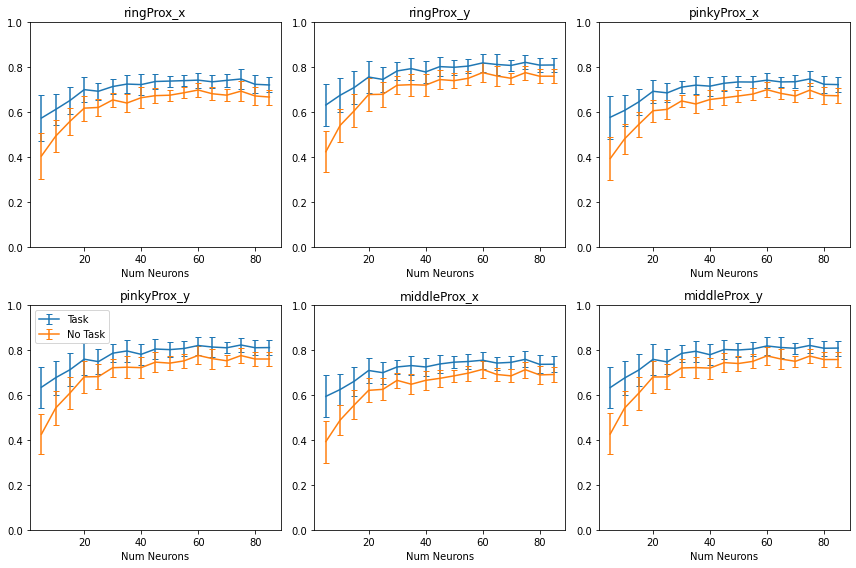

In [42]:
marker_titles = np.concatenate([[f'{mrk}_x', f'{mrk}_y'] for mrk in marker_list])

plt.figure(figsize=(12,8))
for marker_idx in range(6):
    plt.subplot(2,3,marker_idx+1)
    task_mean = np.mean(task_test_corr[:, :, marker_idx], axis=0)
    notask_mean = np.mean(notask_test_corr[:, :, marker_idx], axis=0)
    task_error = np.std(task_test_corr[:, :, marker_idx], axis=0)
    notask_error = np.std(notask_test_corr[:, :, marker_idx], axis=0)

    plt.errorbar(num_neuron_list, task_mean, yerr=task_error, label='Task', capsize=3)
    plt.errorbar(num_neuron_list, notask_mean, yerr=task_error, label='No Task', capsize=3)


    plt.title(f'{marker_titles[marker_idx]}')
    plt.ylim(0,1)
    plt.xlabel('Num Neurons')

    if marker_idx == 3:
        plt.legend()
    plt.tight_layout()

In [43]:
# exclude_processing = np.zeros(len(neural_df['unit'].unique()))
# exclude_processing[-4:] = np.ones(4)
# exclude_processing = exclude_processing.astype(bool)

data_arrays, generators = mocap_functions.make_generators(
wrist_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=None, window_size=window_size,
flip_outputs=True)

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

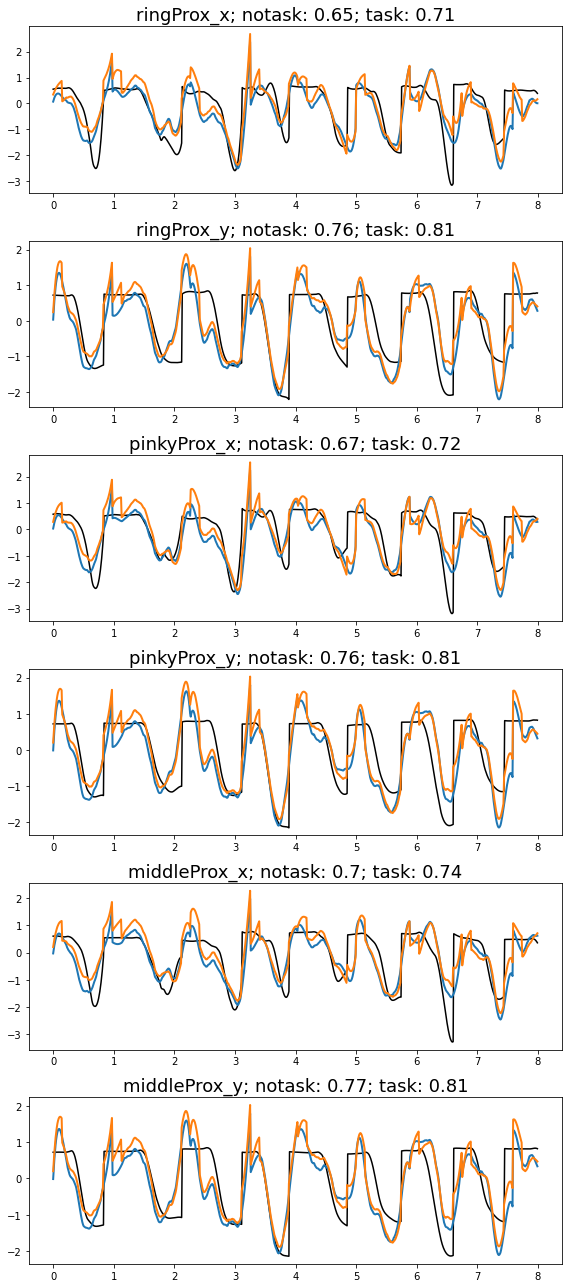

In [44]:
tstart = 0
bounds = np.arange(tstart, tstart + 800)
x_vals = np.arange(len(bounds))/100

decoder_type = 'wiener'
cond1 = 'notask'
cond2 = 'task'

#marker_names = ['Carpal X', 'Carpal Y', 'Radius X', 'Radius Y', 'Ulnar X', 'Ulnar Y']
marker_names = np.concatenate([[f'{mrk}_x', f'{mrk}_y'] for mrk in marker_list])

plt.figure(figsize=(8, 3*(len(marker_names))))
for col_idx in range(len(marker_names)):
    plt.subplot(len(marker_names), 1, col_idx+1)
    plt.plot(x_vals, y_test_data[bounds, col_idx], color='k', label='DLC marker')
    plt.plot(x_vals, decode_results[decoder_type][cond1]['test_pred'][bounds, col_idx], color='C0', linewidth=2, label=cond1)
    plt.plot(x_vals, decode_results[decoder_type][cond2]['test_pred'][bounds, col_idx], color='C1', linewidth=2, label=cond2)


    layout_corr = np.round(decode_results[decoder_type][cond1]['test_corr'][col_idx], 2)
    nolayout_corr = np.round(decode_results[decoder_type][cond2]['test_corr'][col_idx], 2)
    plt.title(f"{marker_names[col_idx]}; {cond1}: {layout_corr}; {cond2}: {nolayout_corr}", fontsize=18)
    
    # if col_idx == 1:
    #     plt.xlabel('Time (s)', fontsize=16)
    # else:
    #     plt.xticks([])

    # if col_idx == 5:
    #     plt.legend()
    
    plt.ylim(plt.ylim())
    plt.xlim(plt.xlim())
    
    #plt.vlines(x=[3, 6, 9, 12],ymin=-10000, ymax=100000, color='k', linewidth=10, linestyle='-', alpha=0.3)
plt.tight_layout()
# plt.savefig(f'movement_decoding_trajectory_{num_neurons}_neurons_layout.png')